# Semantic Segmentation

This Jupyter notebook demonstrates the process of training a DeepLabV3 model on the KITTI dataset for the purpose of semantic segmentation. The goal is to segment distinct areas in automotive environments with relatively low effort.

## Initialization

Initialize the environment by importing the necessary libraries and settin up the file paths.


In [1]:
import os
import sys

# Get the absolute path to the notebook's directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the project root (which is one level up in this case) to sys.path
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importing necessary libraries and modules
from PIL import Image
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from src.models.deeplabv3_model import get_deeplabv3_pretrained
from src.kitti_data_loader import KITTIDataset
from src.train import train_model
from src.cityscapes_labels import labels

## Data Preprocessing and Loading

This section prepares the KITTI dataset for semantic segmentation:

- Define normalization parameters aligned with the pretrained DeepLabV3 model requirements.
- Resize as desired with a minimum height and width of `224` pixels, required by DeepLabV3.
- A custom `KITTIDataset` class is used to load the dataset with the specified transformations.
- Finally, we create a `DataLoader` instance, which will be used for efficient batch processing during model training and evaluation.

For now, crop the images to a minumum size square for quick training.

In [2]:
# Define normalization parameters for the pretrained model
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# Load the dataset with transformations
crop = transforms.CenterCrop((224, 224))
image_transform = transforms.Compose([
    crop,
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

mask_transform = transforms.Compose([
    crop,
])

# Creating a DataLoader instance for the KITTI dataset
dataset = KITTIDataset(image_transform=image_transform, mask_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

## Visualize the Data

### Helper Functions
Define a few functions to help visualize the data.
- `unnormalize `: Reverses the pre-trained model normalization process to display the original image.
- `apply_color_map`: Applies the DeepLabV3 (based on cityscapes) color map to the segmentation mask.

In [3]:
# Define the function to reverse the normalization of images
def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    tensor = tensor.clone()  # Avoid modifying tensor in-place
    tensor.mul_(std).add_(mean)  # Reverse the normalization
    # Convert to [0, 255] range and make it byte type
    tensor = tensor.mul(255).clamp(0, 255).byte()
    # Rearrange dimensions to HxWxC for image processing
    tensor = tensor.cpu().numpy().transpose(1, 2, 0)
    return Image.fromarray(tensor)

# Function to apply color map to the segmentation mask
def apply_color_map(mask, id_to_color):
    # Initialize an empty array for the colored mask
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Map each ID to its corresponding color
    for id, color in id_to_color.items():
        colored_mask[mask == id] = color

    return colored_mask

# Creating a dictionary to map label IDs to their colors
id_to_color = {label.id: label.color for label in labels}
# Map undefined labels to a default color (black)
id_to_color[-1] = (0, 0, 0)  



### Show Sample Data
Grab a few images and their corresponding segmentation masks from the dataset and visually inspect the results.

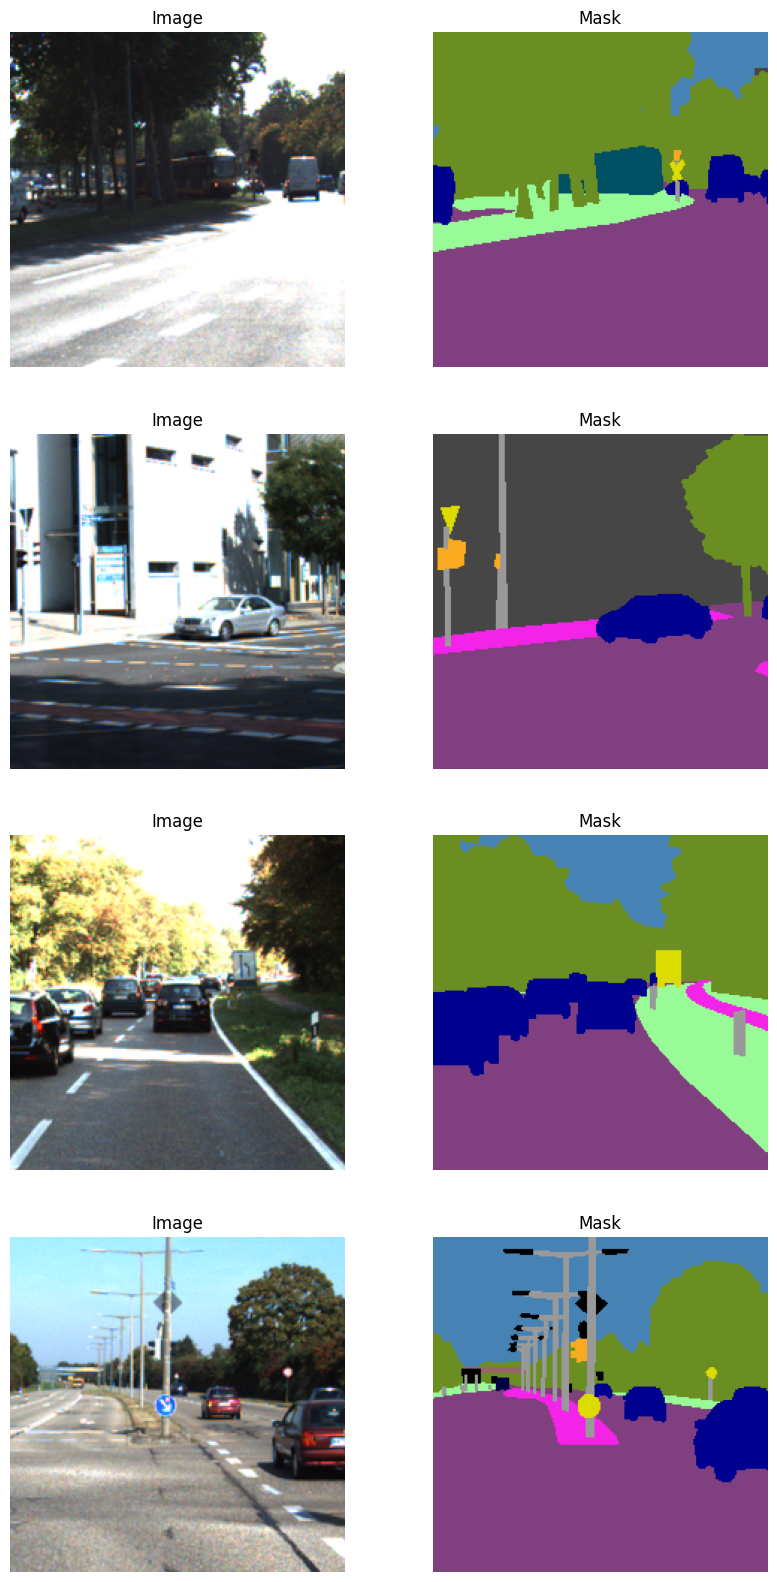

In [4]:
# Fetching a batch of images and masks from the dataloader
batch = next(iter(dataloader))
images, masks = batch

# Visualizing the images and corresponding masks
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(4):
    # Unnormalize and convert to PIL image for display
    unnormalized_img = unnormalize(images[i], mean=norm_mean, std=norm_std)
    ax[i, 0].imshow(unnormalized_img)
    ax[i, 1].imshow(apply_color_map(masks[i].squeeze(), id_to_color=id_to_color))  # Assuming mask is already a 2D tensor
    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.show()

## Model Initalization
Initialize our semenantic segmentation model based on the DeepLabV3 architecture. We will use a pre-trained model and fine-tune it on the KITTI dataset. The original model was trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset. The Kitti pixel-level semantic segmentation dataset contains 35 classes, so we will need to modify the model's final layer to output 35 channels instead of 21.

Check for GPU availability and move the model to the GPU if available.

In [5]:
# Initialize the model
num_classes = 35  # Change based on your dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3_pretrained(num_classes).to(device)
print("Using device: {}".format(device))

Using device: cuda:0


## Define the loss criterion
Here we define the loss criterion for the model. We choose Intersection over Union (IoU) loss, which is particularly effective for segmentation tasks as it directly measures the overlap between the predicted segmentation and the ground truth.

In [6]:
import torch
import torch.nn.functional as F

class IoULoss(torch.nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, outputs, targets):
        # Convert outputs to probabilities using softmax
        outputs = F.softmax(outputs, dim=1)

        # Create one-hot encoding from target indices
        targets_one_hot = F.one_hot(targets, self.num_classes).permute(0, 3, 1, 2)

        # Flatten the tensors to shape (N, C, H*W)
        outputs_flat = outputs.view(outputs.size(0), outputs.size(1), -1)
        targets_flat = targets_one_hot.view(targets_one_hot.size(0), targets_one_hot.size(1), -1)

        # Calculate intersection and union
        intersection = torch.sum(outputs_flat * targets_flat, dim=2)
        union = torch.sum(outputs_flat + targets_flat, dim=2) - intersection

        # Compute IoU and average over batch
        IoU = (intersection + self.smooth) / (union + self.smooth)
        loss = 1 - IoU.mean()

        return loss

## Training
Next, we setup training parameters and train the model.

In [7]:
# Initialize IoU Loss
criterion = IoULoss(num_classes=num_classes)

# Define the loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10  # Change based on your dataset

epoch_losses = train_model(model, dataloader, None, criterion, optimizer, num_epochs, device=device)

Epoch [1/10], Loss: 0.7424
Epoch [2/10], Loss: 0.2433
Epoch [3/10], Loss: 0.2341
Epoch [4/10], Loss: 0.2280
Epoch [5/10], Loss: 0.2240
Epoch [6/10], Loss: 0.2204
Epoch [7/10], Loss: 0.2191
Epoch [8/10], Loss: 0.2162
Epoch [9/10], Loss: 0.2148
Epoch [10/10], Loss: 0.2130


## Dispay Training Results
Show the loss function. Later we will add more plots, such as validation loss.

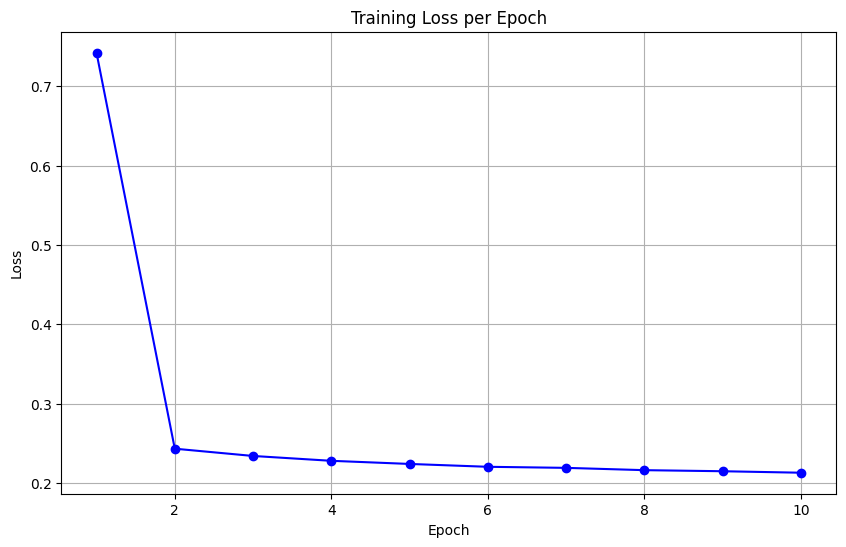

In [8]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Evaluate the Trained Model
Finally, we evaluate the trained model on the test dataset.

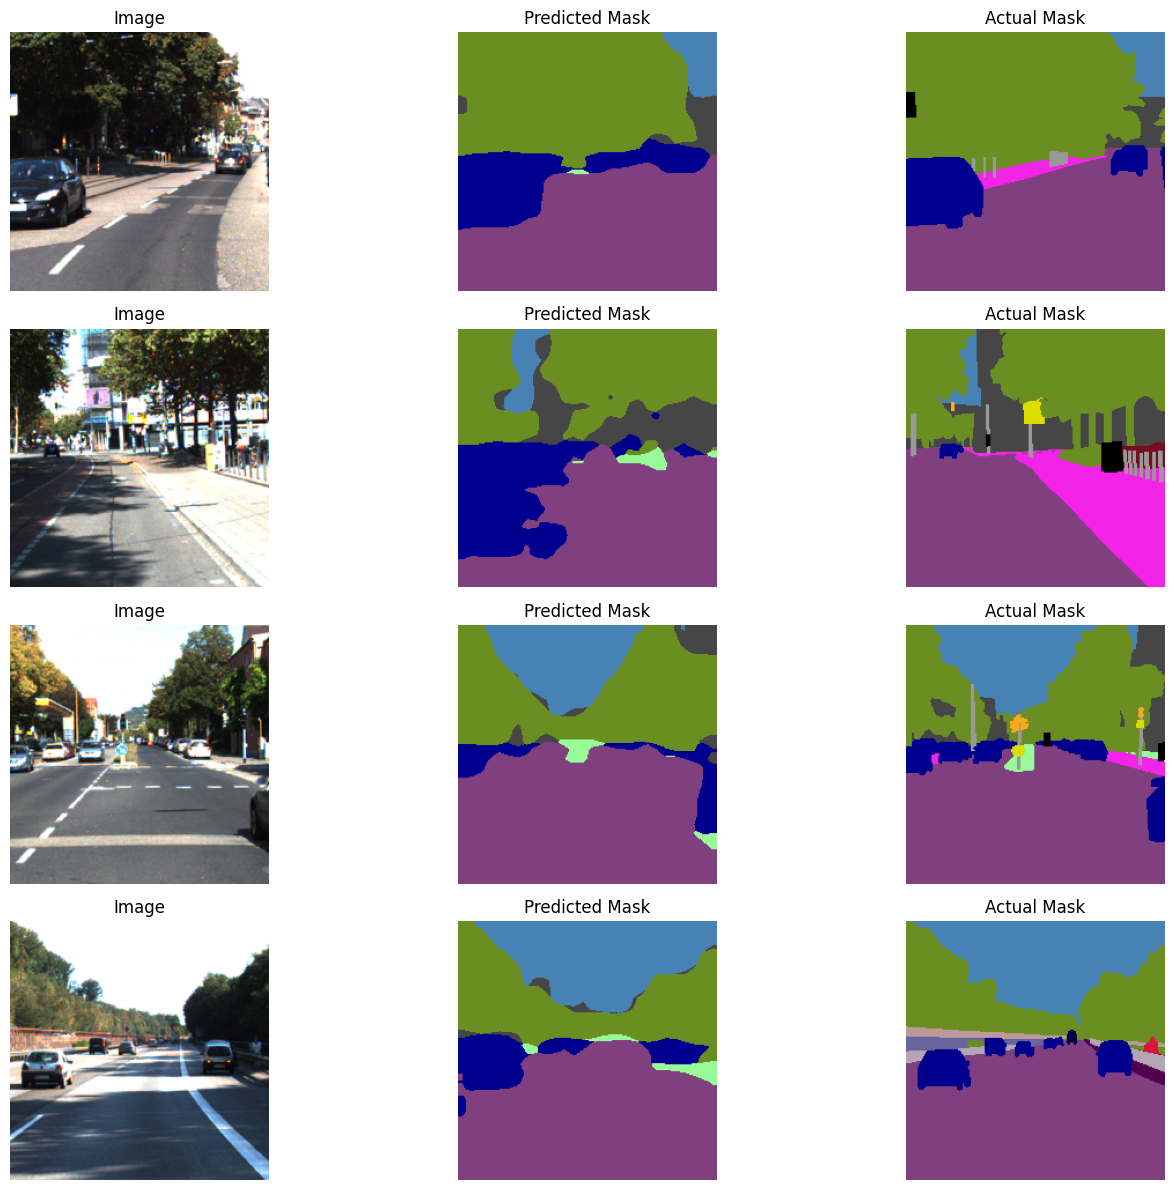

In [9]:
import collections

# Function to display images and corresponding masks
def display_images_masks(images, predicted_masks, actual_masks, mean, std):
    fig, ax = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 3 * len(images)))
    for i in range(len(images)):
        img = unnormalize(images[i], mean, std)
        ax[i, 0].imshow(img)
        # ax[i, 1].imshow(predicted_masks[i].squeeze(), cmap='gray')
        ax[i ,1].imshow(apply_color_map(predicted_masks[i].squeeze(), id_to_color=id_to_color))
        # ax[i, 2].imshow(actual_masks[i].squeeze(), cmap='gray')
        ax[i ,2].imshow(apply_color_map(actual_masks[i].squeeze(), id_to_color=id_to_color))
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Predicted Mask")
        ax[i, 2].set_title("Actual Mask")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        ax[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

# Model inference and display
model.eval()
with torch.no_grad():
    batch = next(iter(dataloader))
    images, masks = batch

    images, masks = images.to(device), masks.to(device)

    # Forward pass through the model
    outputs = model(images)

    # Extract the relevant output tensor from the OrderedDict
    if isinstance(outputs, collections.OrderedDict):
        outputs = outputs['out']

    predicted_masks = torch.argmax(outputs, dim=1)
    display_images_masks(images.cpu(), predicted_masks.cpu(), masks.cpu(), norm_mean, norm_std)

## Conclusion
We have trained a DeepLabV3 model on the KITTI dataset for semantic segmentation. As can be seen, there is room for improvement. With some more work we can expect to achieve better results, as outlined below. For now, we have demonstrated the process of training a semantic segmentation model with mimimal effort thanks to a pre-trained model.

#### Next Steps
- Improved training loop: Add validation loss, hyperparameter tuning, etc.
- Improved data augmentation: Add more data augmentation techniques, such as random cropping, random rotation, etc.
- Improved model: Try different tweaks to the DeepLabV3 model architecture and even other models such as DeepLabV3+.
- Display evaluation results: Add metrics such as IoU, pixel accuracy, etc.